# Image Classification Example

In [1]:
# import sys

# sys.path.insert(0, "image_classifier")

In [2]:
import matplotlib.pyplot as plt
import torch
from hydra_zen import instantiate, to_yaml
from image_classifier import configs

/home/justin_goodwin/.conda/envs/raiden/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


## Dataset

In [3]:
print(to_yaml(configs.CIFAR10DataModule(batch_size=10)))

_target_: hydra_zen.funcs.zen_processing
_zen_target: pytorch_lightning.core.datamodule.LightningDataModule.from_datasets
_zen_exclude:
- root
num_workers: 4
batch_size: 10
train_dataset:
  _target_: image_classifier.utils.random_split
  dataset:
    _target_: torchvision.datasets.cifar.CIFAR10
    root: ${...root}
    train: true
    transform:
      _target_: torchvision.transforms.transforms.Compose
      transforms:
      - _target_: torchvision.transforms.transforms.RandomCrop
        size: 32
        padding: 4
      - _target_: torchvision.transforms.transforms.RandomHorizontalFlip
      - _target_: torchvision.transforms.transforms.ColorJitter
        brightness: 0.25
        contrast: 0.25
        saturation: 0.25
      - _target_: torchvision.transforms.transforms.RandomRotation
        degrees: 2
      - _target_: torchvision.transforms.transforms.ToTensor
      - _target_: torchvision.transforms.transforms.Normalize
        mean:
        - 0.4914
        - 0.4822
        - 

In [4]:
data = instantiate(configs.CIFAR10DataModule(batch_size=10, root="~/.data"))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
x, y = next(iter(data.test_dataloader()))
x.shape

torch.Size([10, 3, 32, 32])

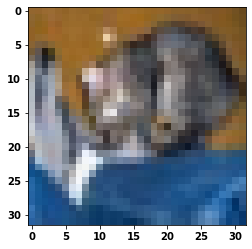

In [6]:
im = x[0].permute(1, 2, 0).numpy()
im = (im - im.min()) / (im.max() - im.min())
plt.imshow(im)

## Model

In [7]:
module = instantiate(
    configs.ImageClassificationConf(model=configs.ResNet18, optim=configs.SGD)
)

### Test with pre-trained model

In [8]:
# Download a version from here
from pathlib import Path

Path("data").mkdir(exist_ok=True)
# ckpt = Path("data") / "torchvision_cifar_l2_1_0.pt"
ckpt = "torchvision_cifar_standard.pt"
# if not ckpt.exists():
#     import requests

#     headers = {"user-agent": "Wget/1.16 (linux-gnu)"}
#     url = "https://www.dropbox.com/s/oagh1e6vji2z252/torchvision_cifar_l2_1_0.pt?dl=1"
#     r = requests.get(url, stream=True, headers=headers)
#     with open(ckpt, "wb") as f:
#         for chunk in r.iter_content(chunk_size=1024):
#             if chunk:
#                 f.write(chunk)

module.load_state_dict(torch.load(ckpt)["state_dict"])

<All keys matched successfully>

In [9]:
module.eval()
module(x).argmax(1) == y

tensor([True, True, True, True, True, True, True, True, True, True])

## Train

In [10]:
# trainer.fit(module, datamodule=data)

## Hydra-Run

In [11]:
from hydra_zen import launch, make_config
from image_classifier.utils import set_seed

In [23]:
def task_function(cfg):
    set_seed(cfg.random_seed)
    data = instantiate(cfg.data)
    model = instantiate(cfg.model)
    optim = instantiate(cfg.optim)
    pl_module = instantiate(cfg.lightning, model=model, optim=optim)
    trainer = instantiate(cfg.trainer)
    if cfg.testing:
        trainer.test(pl_module, datamodule=data)
    else:
        trainer.fit(pl_module, datamodule=data)
    return model

In [29]:
Trainer = configs.TrainerConf(accelerator="dp", max_epochs=1)

Config = make_config(
    defaults=["_self_", dict(model="resnet18"), dict(optim="sgd")],
    data=configs.CIFAR10DataModule,
    model=None,
    optim=None,
    lightning=configs.ImageClassificationConf,
    trainer=Trainer,
    data_dir=str(Path().home() / ".data"),
    random_seed=928,
    testing=False
)

In [30]:
job = launch(
    Config,
    task_function=task_function,
    overrides=[
        "optim.lr=0.05",
        "data.batch_size=512",
    ],
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | predictor | Softmax          | 0     
2 | criterion | CrossEntropyLoss | 0     
3 | metrics   | MetricCollection | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


In [31]:
job.working_dir

'outputs/2021-10-18/15-40-51'

In [32]:
trained_module = job.return_value

## Hydra-Multirun

In [33]:
job = launch(
    Config,
    task_function=task_function,
    overrides=[
        "model=resnet18,resnet50",
        "optim=sgd,adam",
    ],
    multirun=True,
)

[2021-10-18 15:41:11,705][HYDRA] Launching 4 jobs locally
[2021-10-18 15:41:11,705][HYDRA] 	#0 : model=resnet18 optim=sgd
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | predictor | Softmax          | 0     
2 | criterion | CrossEntropyLoss | 0     
3 | metrics   | MetricCollection | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)



[2021-10-18 15:41:27,725][HYDRA] 	#1 : model=resnet18 optim=adam
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | predictor | Softmax          | 0     
2 | criterion | CrossEntropyLoss | 0     
3 | metrics   | MetricCollection | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)



[2021-10-18 15:41:44,339][HYDRA] 	#2 : model=resnet50 optim=sgd
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 23.5 M
1 | predictor | Softmax          | 0     
2 | criterion | CrossEntropyLoss | 0     
3 | metrics   | MetricCollection | 0     
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.083    Total estimated model params size (MB)



[2021-10-18 15:42:20,105][HYDRA] 	#3 : model=resnet50 optim=adam
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 23.5 M
1 | predictor | Softmax          | 0     
2 | criterion | CrossEntropyLoss | 0     
3 | metrics   | MetricCollection | 0     
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.083    Total estimated model params size (MB)


In [34]:
len(job[0])

4

In [35]:
job[0][0].working_dir

'multirun/2021-10-18/15-41-11/0'

In [36]:
print(to_yaml(job[0][0].cfg.model))

_target_: image_classifier.resnet.resnet18



In [37]:
print(to_yaml(job[0][0].cfg.optim))

_target_: hydra_zen.funcs.zen_processing
_zen_target: torch.optim.sgd.SGD
_zen_partial: true
lr: 0.1
momentum: 0.9
dampening: 0
weight_decay: 0
nesterov: false



In [38]:
job[0][0].cfg.data.batch_size

256

In [39]:
isinstance(job[0][0].return_value, torch.nn.Module)

True